In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
country = "US"
#country = 'India'

In [12]:
from jupyterthemes import jtplot
jtplot.style()

Total days in the dataset 472


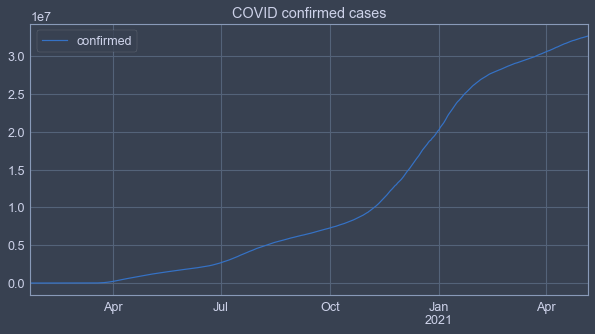

In [13]:
#Total COVID confirmed cases
df_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
#df_confirmed.to_csv('global.csv')
df_confirmed_country = df_confirmed[df_confirmed["Country/Region"] == country]
df_confirmed_country = pd.DataFrame(df_confirmed_country[df_confirmed_country.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

df_confirmed_country.plot(figsize=(10,5),title="COVID confirmed cases")

df_confirmed_country.tail(10)

print("Total days in the dataset", len(df_confirmed_country))


# Define train and test set

In [14]:
#Use data until 14 days before as training
x = len(df_confirmed_country)-14

train=df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

# Scale or Normalize Data

In [15]:
##scale or normalize data as the data is too skewed
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train) 

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

# Generate train and test using Time Series Generator

In [16]:
## Use TimeSeriestrain_generator to generate data in sequences.
#Alternatively we can create our own sequences. 
from keras.preprocessing.sequence import TimeseriesGenerator

#Sequence size has an impact on prediction, especially since COVID is unpredictable!
seq_size = 7  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 271
print("Total number of samples in the generated data = ", len(train_generator)) # 264 with seq_size=7

#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 7 days as x and 8th day as y (for seq_size=7)

#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  458
Total number of samples in the generated data =  451
Total number of samples in the original training data =  14
Total number of samples in the generated data =  7


# Define Model

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')
##########################

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 150)            91200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________
Train...


# Fit Model

Epoch 1/50
10/10 [==============================] - 0s 29ms/step - loss: 0.2052 - val_loss: 0.6727
Epoch 2/50
10/10 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.4115
Epoch 3/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0524 - val_loss: 0.2043
Epoch 4/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0134 - val_loss: 0.0148
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 6/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0302
Epoch 8/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0154 - val_loss: 0.1054
Epoch 9/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 2.1607e-04
Epoch 10/50
10/10 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 11/50
10

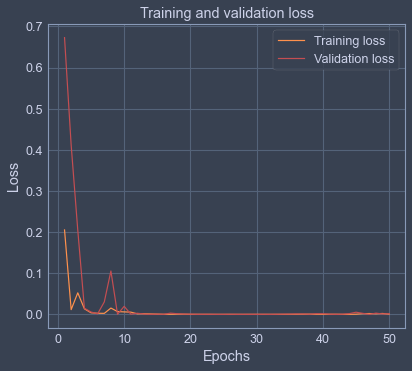

In [18]:
history = model.fit_generator(train_generator, 
                              validation_data=test_generator, 
                              epochs=50, steps_per_epoch=10)


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Forecast

In [19]:
#forecast
prediction = [] #Empty list to populate later with predictions

current_batch = train_scaled[-seq_size:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_size, n_features) #Reshape

## Predict future, beyond test dates
future = 7 #Days
for i in range(len(test) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = scaler.inverse_transform(prediction)

time_series_array = test.index  #Get dates for test data

In [20]:
#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [21]:
#Create a dataframe to capture the forecast data
df_forecast = pd.DataFrame(columns=["actual_confirmed","predicted"], index=time_series_array)

df_forecast.loc[:,"predicted"] = rescaled_prediction[:,0]
df_forecast.loc[:,"actual_confirmed"] = test["confirmed"]

## Forecast Plot

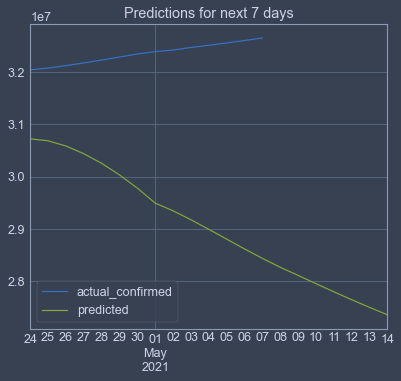

In [22]:
#Plot
df_forecast.plot(title="Predictions for next 7 days")